# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
pip install scipy==1.1.0

  Using cached scipy-1.1.0-cp36-cp36m-manylinux1_x86_64.whl (31.2 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import cv2
from skimage import io
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
from tensorflow.keras import backend as K
tf.random.set_seed(30)
import warnings
warnings.filterwarnings("ignore")

In [4]:
!pip install Pillow
import PIL

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())

In [6]:
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'

360 360


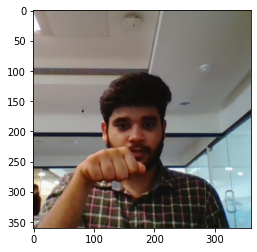

In [7]:
#Checking for the images
image1 = PIL.Image.open(train_path+'/WIN_20180907_15_43_40_Pro_Stop Gesture_new/WIN_20180907_15_43_40_Pro_00011.png')
w,h = image1.size
print(w,h)
image1=imread(train_path+'/WIN_20180907_15_43_40_Pro_Stop Gesture_new/WIN_20180907_15_43_40_Pro_00011.png')
plt.imshow(image1)

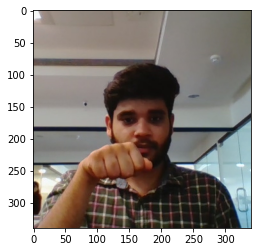

In [8]:
#Verifying cropping output on sample images
image1=imread(train_path+'/WIN_20180907_15_43_40_Pro_Stop Gesture_new/WIN_20180907_15_43_40_Pro_00011.png')
image1 = image1[20:,:-20]
plt.imshow(image1)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
class VideoGenerator:

   # Function for defining image size
    def imageparam(self,image_height,image_width):
        self.image_height=image_height
        self.image_width=image_width

    # Function to define few other parameters
    def othergenparam(self,num_epoches,batch_size,num_images):
        self.num_epoches=num_epoches
        self.batch_size=batch_size
        self.num_images=num_images

    # Generator Function
    def generator(self,source_path,folder_list):
        print( 'Source path = ', source_path, '; batch size =', self.batch_size)
        img_idx = (np.linspace(0,29,self.num_images)).astype(int)
        #create a list of image numbers you want to use for a particular video
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(folder_list)//self.batch_size # calculate the number of batches
            x=len(img_idx)
            y=self.image_width
            z=self.image_height
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data = np.zeros((self.batch_size,x,y,z,3)) 
                #x is the number of images you use for each video,
                # (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((self.batch_size,5)) # batch_labels is the one hot representation of the output
                for folder in range(self.batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*self.batch_size)].split(';')[0]) 
            
                    # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*self.batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
        
                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        
                        #cropping the image
                        #selecting [20:,:-20] matrix as it seemed to be most suitable for maximum images
                    
                        #resizing the image
                        image = image[20:,:-20]
                        image = resize(image,(y,z,3))
                        
                        #batch_data[folder,idx,:,:,0] = image[:,:,0]-(image.mean()) #normalise and feed in the image
                        batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                        
                    batch_labels[folder, int(t[folder + (batch*self.batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

            
            # write the code for the remaining data points which are left after full batches
            rem_data = len(folder_list)%self.batch_size
            if (rem_data != 0) :
                batch_size = rem_data
                num_batches = 1
                for batch in range(num_batches): # we iterate over the number of batches
                    batch_data = np.zeros((batch_size,x,y,z,3)) 
                    #x is the number of images you use for each video,
                    # (y,z) is the final size of the input images and 3 is the number of channels RGB
                    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
                    for folder in range(batch_size): # iterate over the batch_size
                        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
                    
                        # read all the images in the folder
                        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                            
                            #crop the images and resize them. Note that the images are of 2 different shape 
                            #and the conv3D will throw error if the inputs in a batch have different shapes

                            #cropping the image
                            #selecting [20:,:-20] matrix as it seemed to be most suitable for maximum images
                            #resizing the image
                            
                            image = image[20:,:-20]
                            image = resize(image,(y,z,3))
                            
                            batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                            batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                            batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image

                        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                    yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

    #Function to define parameters for model training           
    def train_model(self,model):

        curr_dt_time = datetime.datetime.now()

        num_train_sequences = len(train_doc)
        print('# training sequences =', num_train_sequences)
        num_val_sequences = len(val_doc)
        print('# validation sequences =', num_val_sequences)
        num_epoches = self.num_epoches # choose the number of epochs
        print ('# epoches =', num_epoches)

        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
                
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
        
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1,min_lr=0.00001) # write the REducelronplateau code here
        #using high factor value here as the validation accuracy is very low compared to train accuracy
        
        callbacks_list = [checkpoint, LR]
        
        #steps per epoch for train data
        if (num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (num_train_sequences//self.batch_size) + 1

        #steps per epoch for val data
        if (num_val_sequences%self.batch_size) == 0:
            validation_steps = int(num_val_sequences/self.batch_size)
        else:
            validation_steps = (num_val_sequences//self.batch_size) + 1

        train_generator = self.generator(train_path,train_doc)
        val_generator = self.generator(val_path,val_doc)

        # Model Fit 
        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epoches, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
       
        return history

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,LSTM,Dropout,SimpleRNN
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.optimizers import Adam,SGD
from skimage.transform import resize

# 3D RNN model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
class modelbuild3D1(VideoGenerator):
    def model_definition(self,filter=(3,3,3),dense_neurons=64,dropout=0.25):
        input_shape_model = (self.num_images,self.image_width,self.image_height,3)
        model = Sequential()
        model.add(Conv3D(16, filter, padding='same',input_shape=input_shape_model))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model
        

##### Using Batch Size = 100 , num_images=15 and Image Dimesnsions as 160

In [49]:
conv_3D1=modelbuild3D1()
conv_3D1.imageparam(image_height=160,image_width=160)
conv_3D1.othergenparam(num_epoches=5,batch_size=100,num_images=15)
conv_3D1_model=conv_3D1.model_definition()
conv_3D1_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 15, 160, 160, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 15, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 15, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 7, 80, 80, 16)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 7, 80, 80, 32)     13856     
_________________________________________________________________
activation_13 (Activation)   (None, 7, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 7, 80, 80, 32)    

In [50]:
print("Total Params:", conv_3D1_model.count_params())
model1 = conv_3D1.train_model(conv_3D1_model)

Total Params: 1714437
# training sequences = 663
# validation sequences = 100
# epoches = 5
Source path =  datasets/Project_data/train ; batch size = 100
Epoch 1/5


ResourceExhaustedError:  OOM when allocating tensor with shape[100,16,15,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential_4/max_pooling3d_12/MaxPool3D/MaxPool3DGrad (defined at <ipython-input-46-46a545f52812>:134) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_10061]

Function call stack:
train_function


##### Batch Size=100 has resulted in Resource Exhaustion error, reducing the Batch size

In [51]:
conv_3D2=modelbuild3D1()
conv_3D2.imageparam(image_height=160,image_width=160)
conv_3D2.othergenparam(num_epoches=5,batch_size=75,num_images=15)
conv_3D2_model=conv_3D2.model_definition()
conv_3D2_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 15, 160, 160, 16)  1312      
_________________________________________________________________
activation_15 (Activation)   (None, 15, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 15, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 7, 80, 80, 16)     0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 7, 80, 80, 32)     13856     
_________________________________________________________________
activation_16 (Activation)   (None, 7, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 7, 80, 80, 32)    

In [52]:
print("Total Params:", conv_3D2_model.count_params())
model2 = conv_3D2.train_model(conv_3D2_model)

Total Params: 1714437
# training sequences = 663
# validation sequences = 100
# epoches = 5
Source path =  datasets/Project_data/train ; batch size = 75
Epoch 1/5
9/9 [==============================] - ETA: 0s - loss: 1.4928 - categorical_accuracy: 0.4389Source path =  datasets/Project_data/val ; batch size = 75

Epoch 00001: saving model to model_init_2021-10-2316_06_36.294442/model-00001-1.49278-0.43891-1.71511-0.24000.h5
9/9 [==============================] - 93s 10s/step - loss: 1.4928 - categorical_accuracy: 0.4389 - val_loss: 1.7151 - val_categorical_accuracy: 0.2400
Epoch 2/5
9/9 [==============================] - ETA: 0s - loss: 1.6148 - categorical_accuracy: 0.1780
Epoch 00002: saving model to model_init_2021-10-2316_06_36.294442/model-00002-1.61484-0.17798-1.76408-0.15000.h5
9/9 [==============================] - 86s 10s/step - loss: 1.6148 - categorical_accuracy: 0.1780 - val_loss: 1.7641 - val_categorical_accuracy: 0.1500
Epoch 3/5
9/9 [==============================] - ETA

In [9]:
import matplotlib.pyplot as plt
def plot(history):
    fig, axes = plt.subplots(1,2, figsize=(15,4))

    axes[0].plot(history.history['categorical_accuracy'],label='Training Accuracy')   
    axes[0].plot(history.history['val_categorical_accuracy'],label='Validation Accuracy')
    axes[0].legend(loc='lower right')
    axes[0].title.set_text('Training and Validation Accuracy')

    axes[1].plot(history.history['loss'],label='Training Loss')   
    axes[1].plot(history.history['val_loss'],label='Validation Loss')
    axes[1].legend(loc='upper right')
    axes[1].title.set_text('Training and Validation Loss')

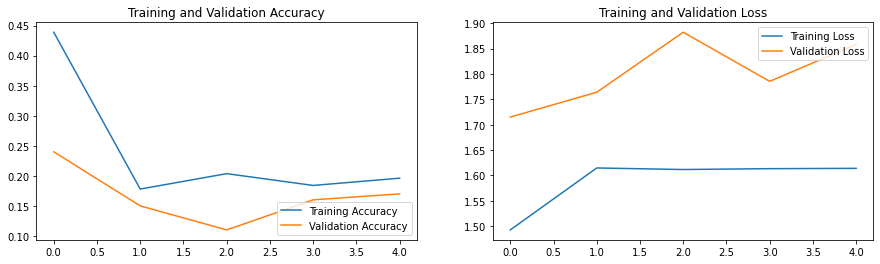

In [54]:
plot(model2)

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [55]:
#Changing number of images
conv_3D3=modelbuild3D1()
conv_3D3.imageparam(image_height=160,image_width=160)
conv_3D3.othergenparam(num_epoches=5,batch_size=75,num_images=20)
conv_3D3_model=conv_3D3.model_definition()
conv_3D3_model.summary()
print("Total Params:", conv_3D3_model.count_params())
model3 = conv_3D3.train_model(conv_3D3_model)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_18 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_18 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_19 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 10, 80, 80, 32)   

ResourceExhaustedError:  OOM when allocating tensor with shape[75,16,20,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential_6/max_pooling3d_18/MaxPool3D/MaxPool3DGrad (defined at <ipython-input-46-46a545f52812>:134) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_15389]

Function call stack:
train_function


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_1 (Activation)    (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 60, 60, 32)     1

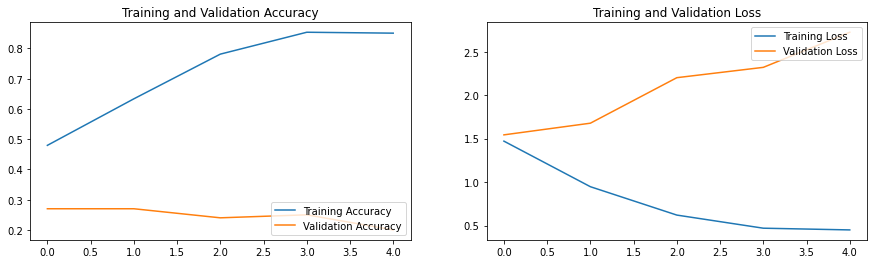

In [14]:
#Looking at the impact of changing image dimensions only
conv_3D4_1=modelbuild3D1()
conv_3D4_1.imageparam(image_height=120,image_width=120)
conv_3D4_1.othergenparam(num_epoches=5,batch_size=75,num_images=15)
conv_3D4_1_model=conv_3D4_1.model_definition()
conv_3D4_1_model.summary()
print("Total Params:", conv_3D4_1_model.count_params())
model4_1 = conv_3D4_1.train_model(conv_3D4_1_model)
plot(model4_1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
activation_3 (Activation)    (None, 15, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 7, 50, 50, 32)     13856     
_________________________________________________________________
activation_4 (Activation)    (None, 7, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 50, 50, 32)    

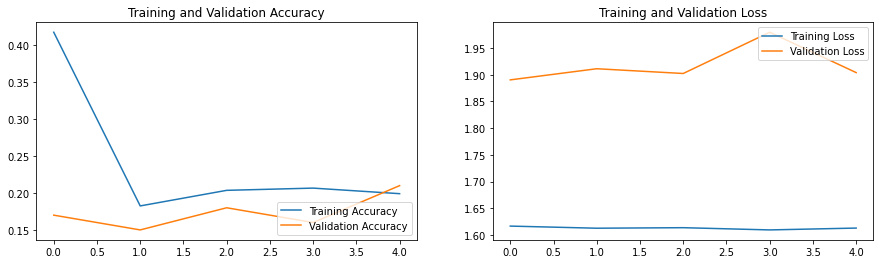

In [15]:
#Looking at the impact of changing image dimensions further only
conv_3D4_2=modelbuild3D1()
conv_3D4_2.imageparam(image_height=100,image_width=100)
conv_3D4_2.othergenparam(num_epoches=5,batch_size=75,num_images=15)
conv_3D4_2_model=conv_3D4_2.model_definition()
conv_3D4_2_model.summary()
print("Total Params:", conv_3D4_2_model.count_params())
model4_2 = conv_3D4_2.train_model(conv_3D4_2_model)
plot(model4_2)

In [56]:
#Changing number of images =20
conv_3D4=modelbuild3D1()
conv_3D4.imageparam(image_height=120,image_width=120)
conv_3D4.othergenparam(num_epoches=5,batch_size=75,num_images=20)
conv_3D4_model=conv_3D4.model_definition()
conv_3D4_model.summary()
print("Total Params:", conv_3D4_model.count_params())
model4 = conv_3D4.train_model(conv_3D4_model)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_21 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_22 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 10, 60, 60, 32)   

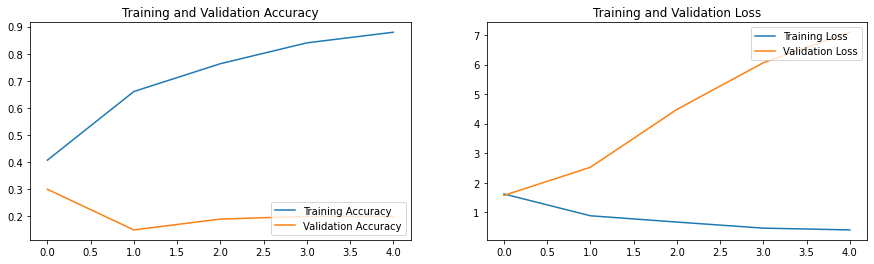

In [57]:
plot(model4)
# Seeing this we can see by increasing number of images , there is not much improvement in training and validation accuracy and validation loss 
#has shoot up and number of parameters has increased tremendously.

In [58]:
#Changing batch size
conv_3D4=modelbuild3D1()
conv_3D4.imageparam(image_height=120,image_width=120)
conv_3D4.othergenparam(num_epoches=5,batch_size=50,num_images=20)
conv_3D4_model=conv_3D4.model_definition()
conv_3D4_model.summary()
print("Total Params:", conv_3D4_model.count_params())
model4 = conv_3D4.train_model(conv_3D4_model)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_24 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_25 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 10, 60, 60, 32)   

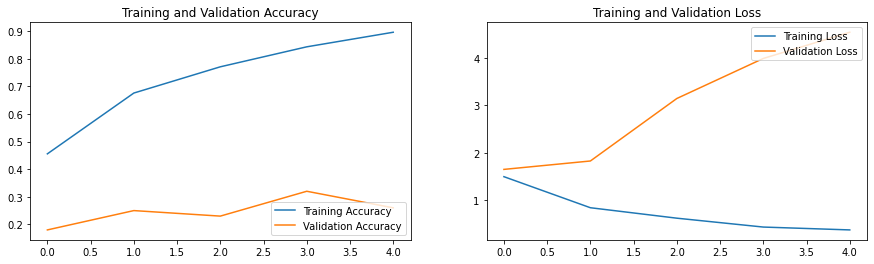

In [59]:
plot(model4)
# Decreasing Batch size from 75 to 50 has improved the accuracy of training and validation data with no change in number of 
#trainable parameters

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_6 (Activation)    (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_7 (Activation)    (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 7, 60, 60, 32)    

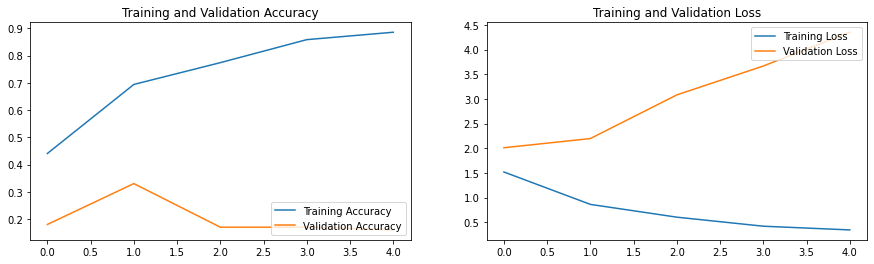

In [16]:
#Changing batch size
conv_3D4_4=modelbuild3D1()
conv_3D4_4.imageparam(image_height=120,image_width=120)
conv_3D4_4.othergenparam(num_epoches=5,batch_size=50,num_images=15)
conv_3D4_4_model=conv_3D4_4.model_definition()
conv_3D4_4_model.summary()
print("Total Params:", conv_3D4_4_model.count_params())
model4_4 = conv_3D4_4.train_model(conv_3D4_4_model)
plot(model4_4)

In [60]:
#As we have seen decreasing the batch size has improved some accuracy, Changing batch size again to see the effect
conv_3D4=modelbuild3D1()
conv_3D4.imageparam(image_height=120,image_width=120)
conv_3D4.othergenparam(num_epoches=5,batch_size=40,num_images=20)
conv_3D4_model=conv_3D4.model_definition()
conv_3D4_model.summary()
print("Total Params:", conv_3D4_model.count_params())
model4 = conv_3D4.train_model(conv_3D4_model)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_27 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_27 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_27 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_28 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_28 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 10, 60, 60, 32)   

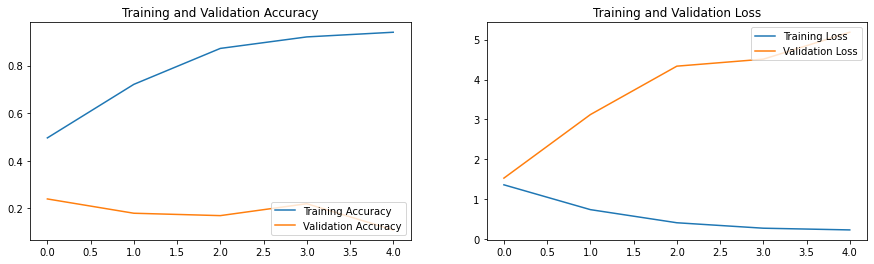

In [61]:
plot(model4)
#Difference between training acc and val accuracy has increased

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 18, 120, 120, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 18, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 18, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 9, 60, 60, 16)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 9, 60, 60, 32)     13856     
_________________________________________________________________
activation_10 (Activation)   (None, 9, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 9, 60, 60, 32)    

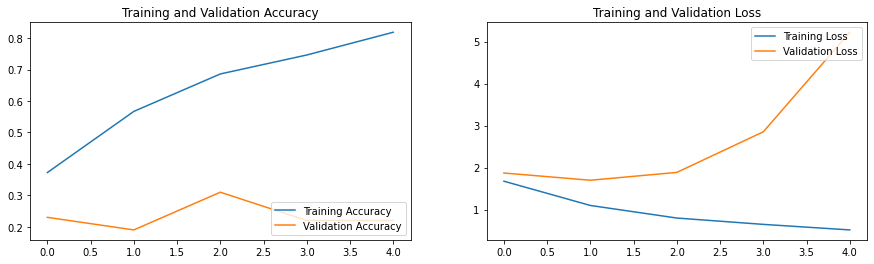

In [17]:
#Changing number of images
conv_3D4_5=modelbuild3D1()
conv_3D4_5.imageparam(image_height=120,image_width=120)
conv_3D4_5.othergenparam(num_epoches=5,batch_size=40,num_images=18)
conv_3D4_5_model=conv_3D4_5.model_definition()
conv_3D4_5_model.summary()
print("Total Params:", conv_3D4_5_model.count_params())
model4_5 = conv_3D4_5.train_model(conv_3D4_5_model)
plot(model4_5)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 22, 120, 120, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 22, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 22, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 11, 60, 60, 16)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 11, 60, 60, 32)    13856     
_________________________________________________________________
activation_13 (Activation)   (None, 11, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 11, 60, 60, 32)   

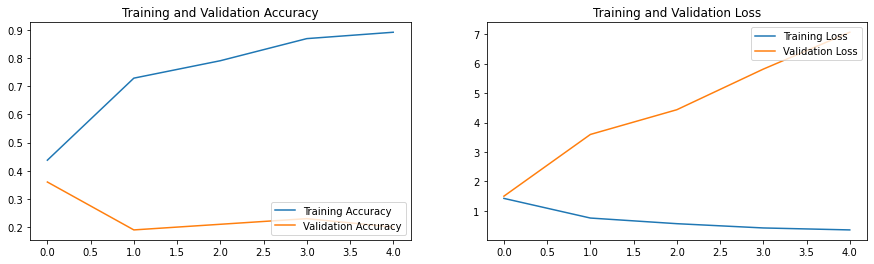

In [18]:
#Changing number of imagesto 22
conv_3D4_6=modelbuild3D1()
conv_3D4_6.imageparam(image_height=120,image_width=120)
conv_3D4_6.othergenparam(num_epoches=5,batch_size=40,num_images=22)
conv_3D4_6_model=conv_3D4_6.model_definition()
conv_3D4_6_model.summary()
print("Total Params:", conv_3D4_6_model.count_params())
model4_6 = conv_3D4_6.train_model(conv_3D4_6_model)
plot(model4_6)

In [62]:
#num_images=15
conv_3D4=modelbuild3D1()
conv_3D4.imageparam(image_height=120,image_width=120)
conv_3D4.othergenparam(num_epoches=5,batch_size=40,num_images=15)
conv_3D4_model=conv_3D4.model_definition()
conv_3D4_model.summary()
print("Total Params:", conv_3D4_model.count_params())
model4 = conv_3D4.train_model(conv_3D4_model)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_30 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_30 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_30 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_31 (Conv3D)           (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_31 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_51 (Batc (None, 7, 60, 60, 32)   

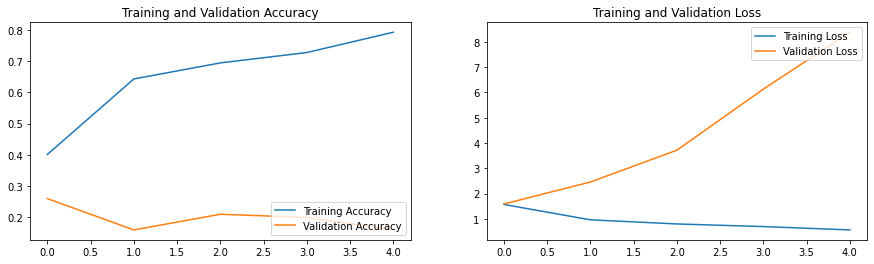

In [63]:
plot(model4)

In [14]:
class modelbuild3D2(VideoGenerator):
    def model_definition(self,filter=(3,3,3),dense_neurons=128,dropout=0.25):
        input_shape_model = (self.num_images,self.image_width,self.image_height,3)
        model = Sequential()
        model.add(Conv3D(16, filter, padding='same',input_shape=input_shape_model))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model
        

In [65]:
#num_images=15,batchsize=50
conv_3D2_1=modelbuild3D2()
conv_3D2_1.imageparam(image_height=120,image_width=120)
conv_3D2_1.othergenparam(num_epoches=5,batch_size=50,num_images=15)
conv_3D2_1_model=conv_3D2_1.model_definition()
conv_3D2_1_model.summary()
print("Total Params:", conv_3D2_1_model.count_params())
model2_1 = conv_3D2_1.train_model(conv_3D2_1_model)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_33 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_33 (MaxPooling (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_34 (Activation)   (None, 7, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 7, 60, 60, 32)   

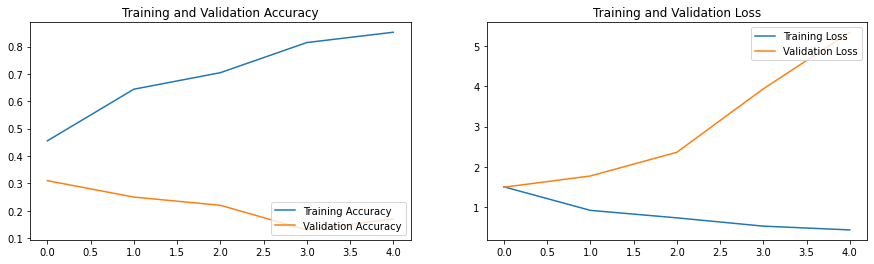

In [66]:
plot(model2_1)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_36 (Conv3D)           (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
activation_36 (Activation)   (None, 15, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 15, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_36 (MaxPooling (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 7, 50, 50, 32)     13856     
_________________________________________________________________
activation_37 (Activation)   (None, 7, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 7, 50, 50, 32)   

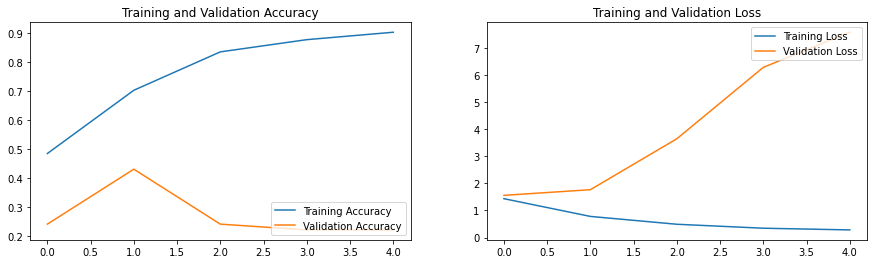

In [67]:
#changing image dimensions
conv_3D2_2=modelbuild3D2()
conv_3D2_2.imageparam(image_height=100,image_width=100)
conv_3D2_2.othergenparam(num_epoches=5,batch_size=50,num_images=15)
conv_3D2_2_model=conv_3D2_2.model_definition()
conv_3D2_2_model.summary()
print("Total Params:", conv_3D2_2_model.count_params())
model2_2 = conv_3D2_2.train_model(conv_3D2_2_model)
plot(model2_2)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_39 (Conv3D)           (None, 20, 100, 100, 16)  1312      
_________________________________________________________________
activation_39 (Activation)   (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_65 (Batc (None, 20, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_39 (MaxPooling (None, 10, 50, 50, 16)    0         
_________________________________________________________________
conv3d_40 (Conv3D)           (None, 10, 50, 50, 32)    13856     
_________________________________________________________________
activation_40 (Activation)   (None, 10, 50, 50, 32)    0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 10, 50, 50, 32)  

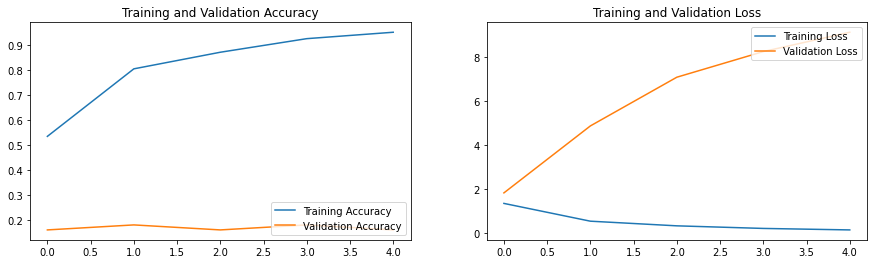

In [68]:
#changing num_images dimensions
conv_3D2_3=modelbuild3D2()
conv_3D2_3.imageparam(image_height=100,image_width=100)
conv_3D2_3.othergenparam(num_epoches=5,batch_size=50,num_images=20)
conv_3D2_3_model=conv_3D2_3.model_definition()
conv_3D2_3_model.summary()
print("Total Params:", conv_3D2_3_model.count_params())
model2_3 = conv_3D2_3.train_model(conv_3D2_3_model)
plot(model2_3)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 60, 60, 32)    1

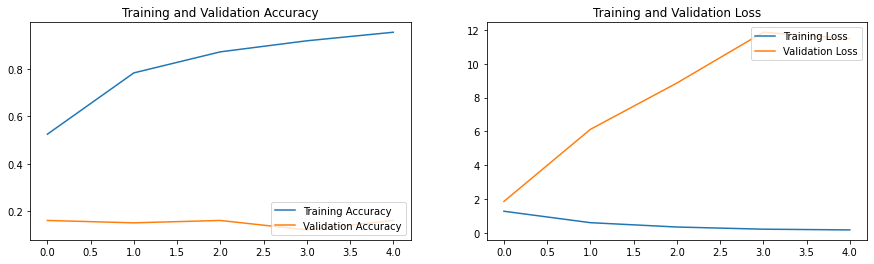

In [15]:
#changing num_images dimensions
conv_3D2_4=modelbuild3D2()
conv_3D2_4.imageparam(image_height=120,image_width=120)
conv_3D2_4.othergenparam(num_epoches=5,batch_size=50,num_images=20)
conv_3D2_4_model=conv_3D2_4.model_definition()
conv_3D2_4_model.summary()
print("Total Params:", conv_3D2_4_model.count_params())
model2_4 = conv_3D2_4.train_model(conv_3D2_4_model)
plot(model2_4)

#### Adding 1 more layer 3D

In [21]:
class modelbuild3D3(VideoGenerator):
    def model_definition(self,filter=(3,3,3),dense_neurons=64,dropout=0.25):
        input_shape_model = (self.num_images,self.image_width,self.image_height,3)
        model = Sequential()
        model.add(Conv3D(16, filter, padding='same',input_shape=input_shape_model))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(128, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model
        

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_18 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_18 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_19 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 10, 80, 80, 32)   

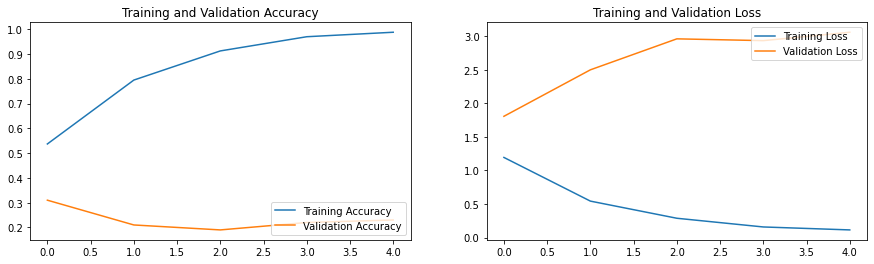

In [22]:
#changing num_images dimensions
conv_3D3_1=modelbuild3D3()
conv_3D3_1.imageparam(image_height=160,image_width=160)
conv_3D3_1.othergenparam(num_epoches=5,batch_size=40,num_images=20)
conv_3D3_1_model=conv_3D3_1.model_definition()
conv_3D3_1_model.summary()
print("Total Params:", conv_3D3_1_model.count_params())
model3_1 = conv_3D3_1.train_model(conv_3D3_1_model)
plot(model3_1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_22 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_22 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_23 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_23 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 10, 60, 60, 32)   

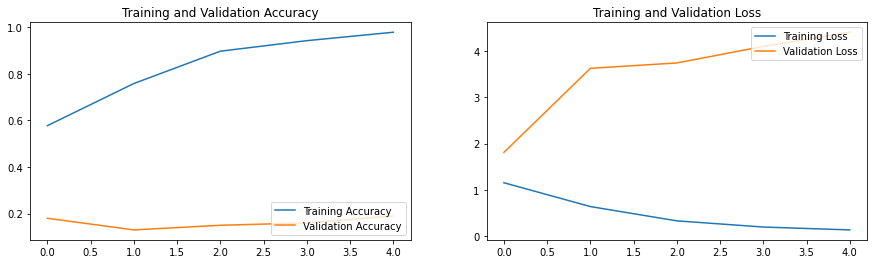

In [23]:
#changing num_images dimensions
conv_3D3_2=modelbuild3D3()
conv_3D3_2.imageparam(image_height=120,image_width=120)
conv_3D3_2.othergenparam(num_epoches=5,batch_size=40,num_images=20)
conv_3D3_2_model=conv_3D3_2.model_definition()
conv_3D3_2_model.summary()
print("Total Params:", conv_3D3_2_model.count_params())
model3_2 = conv_3D3_2.train_model(conv_3D3_2_model)
plot(model3_2)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_38 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_38 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_38 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_39 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_39 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 10, 60, 60, 32)  

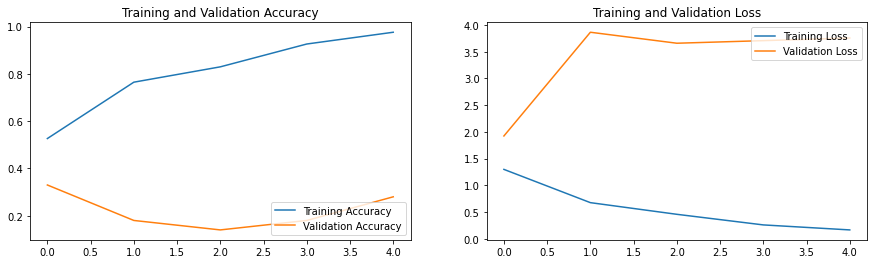

In [28]:
#changing num_images dimensions
conv_3D3_3=modelbuild3D3()
conv_3D3_3.imageparam(image_height=120,image_width=120)
conv_3D3_3.othergenparam(num_epoches=5,batch_size=30,num_images=20)
conv_3D3_3_model=conv_3D3_3.model_definition()
conv_3D3_3_model.summary()
print("Total Params:", conv_3D3_3_model.count_params())
model3_3 = conv_3D3_3.train_model(conv_3D3_3_model)
plot(model3_3)

In [24]:
class modelbuild3D4(VideoGenerator):
    def model_definition(self,filter=(3,3,3),dense_neurons=64,dropout=0.25):
        input_shape_model = (self.num_images,self.image_width,self.image_height,3)
        model = Sequential()
        model.add(Conv3D(16, filter, padding='same',input_shape=input_shape_model))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(128, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model
        

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_26 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_26 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_26 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_27 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 10, 60, 60, 32)   

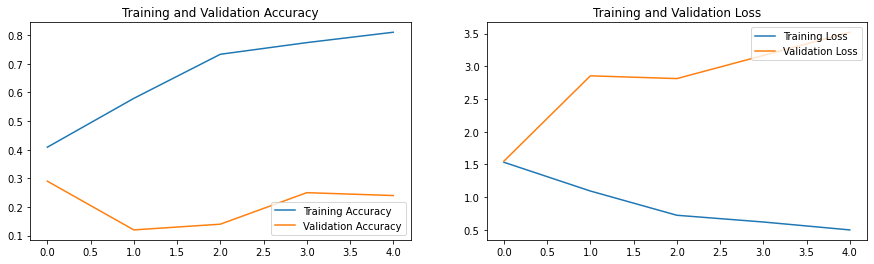

In [25]:
#changing num_images dimensions
conv_3D4_1=modelbuild3D4()
conv_3D4_1.imageparam(image_height=120,image_width=120)
conv_3D4_1.othergenparam(num_epoches=5,batch_size=40,num_images=20)
conv_3D4_1_model=conv_3D4_1.model_definition()
conv_3D4_1_model.summary()
print("Total Params:", conv_3D4_1_model.count_params())
model4_1 = conv_3D4_1.train_model(conv_3D4_1_model)
plot(model4_1)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_30 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_30 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_30 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_31 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_31 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 10, 60, 60, 32)   

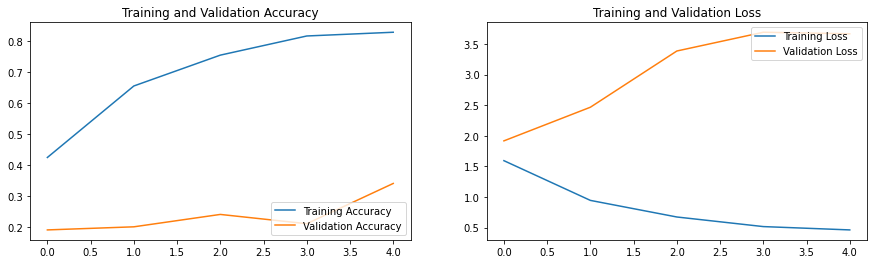

In [26]:
#changing num_images dimensions
conv_3D4_2=modelbuild3D4()
conv_3D4_2.imageparam(image_height=120,image_width=120)
conv_3D4_2.othergenparam(num_epoches=5,batch_size=30,num_images=20)
conv_3D4_2_model=conv_3D4_2.model_definition()
conv_3D4_2_model.summary()
print("Total Params:", conv_3D4_2_model.count_params())
model4_2 = conv_3D4_2.train_model(conv_3D4_2_model)
plot(model4_2)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_34 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_34 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_34 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_35 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_35 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_51 (Batc (None, 10, 60, 60, 32)  

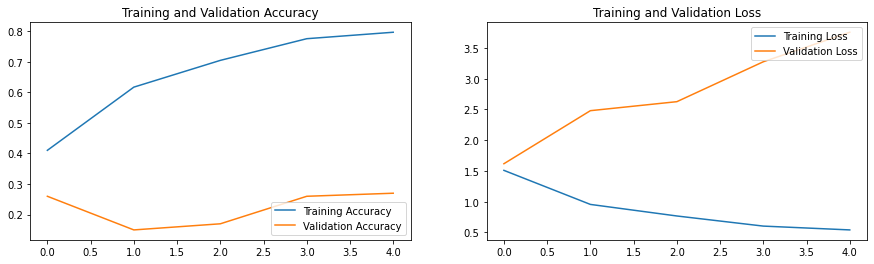

In [27]:
#changing num_images dimensions
conv_3D4_3=modelbuild3D4()
conv_3D4_3.imageparam(image_height=120,image_width=120)
conv_3D4_3.othergenparam(num_epoches=5,batch_size=25,num_images=20)
conv_3D4_3_model=conv_3D4_3.model_definition()
conv_3D4_3_model.summary()
print("Total Params:", conv_3D4_3_model.count_params())
model4_3 = conv_3D4_3.train_model(conv_3D4_3_model)
plot(model4_3)

In [29]:
#Changing Dropout
class modelbuild3D5(VideoGenerator):
    def model_definition(self,filter=(3,3,3),dense_neurons=64,dropout=0.5):
        input_shape_model = (self.num_images,self.image_width,self.image_height,3)
        model = Sequential()
        model.add(Conv3D(16, filter, padding='same',input_shape=input_shape_model))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(128, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model
        

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_42 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_42 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_42 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_43 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_43 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_62 (Batc (None, 10, 60, 60, 32)  

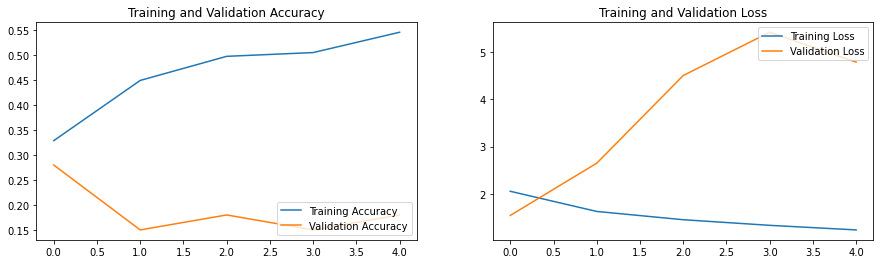

In [30]:
#changing num_images dimensions
conv_3D5_1=modelbuild3D5()
conv_3D5_1.imageparam(image_height=120,image_width=120)
conv_3D5_1.othergenparam(num_epoches=5,batch_size=30,num_images=20)
conv_3D5_1_model=conv_3D5_1.model_definition()
conv_3D5_1_model.summary()
print("Total Params:", conv_3D5_1_model.count_params())
model5_1 = conv_3D5_1.train_model(conv_3D5_1_model)
plot(model5_1)

In [13]:
#Changing Dropout
class modelbuild3D6(VideoGenerator):
    def model_definition(self,filter=(3,3,3),dense_neurons=64,dropout=0.2):
        input_shape_model = (self.num_images,self.image_width,self.image_height,3)
        model = Sequential()
        model.add(Conv3D(16, filter, padding='same',input_shape=input_shape_model))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(128, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model
        

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 60, 60, 32)    1

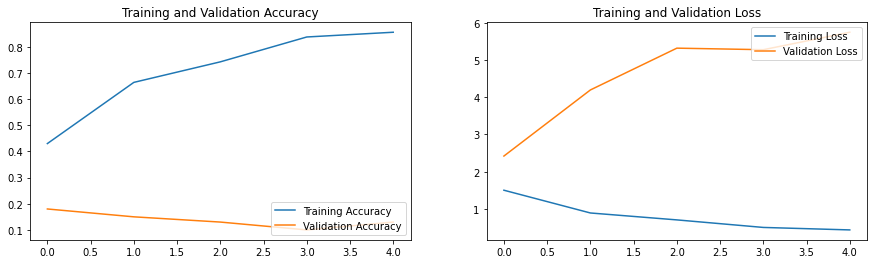

In [14]:
#changing num_images dimensions
conv_3D6_1=modelbuild3D6()
conv_3D6_1.imageparam(image_height=120,image_width=120)
conv_3D6_1.othergenparam(num_epoches=5,batch_size=30,num_images=20)
conv_3D6_1_model=conv_3D6_1.model_definition()
conv_3D6_1_model.summary()
print("Total Params:", conv_3D6_1_model.count_params())
model6_1 = conv_3D6_1.train_model(conv_3D6_1_model)
plot(model6_1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_5 (Activation)    (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 10, 60, 60, 32)   

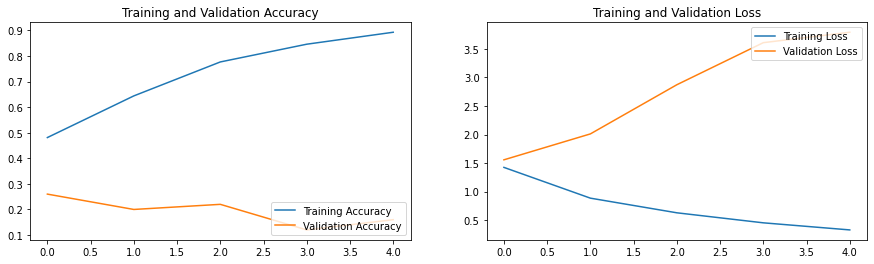

In [15]:
#changing batch size
conv_3D6_2=modelbuild3D6()
conv_3D6_2.imageparam(image_height=120,image_width=120)
conv_3D6_2.othergenparam(num_epoches=5,batch_size=40,num_images=20)
conv_3D6_2_model=conv_3D6_2.model_definition()
conv_3D6_2_model.summary()
print("Total Params:", conv_3D6_2_model.count_params())
model6_2 = conv_3D6_2.train_model(conv_3D6_2_model)
plot(model6_2)

In [16]:
#Changing number of neurons
class modelbuild3D7(VideoGenerator):
    def model_definition(self,filter=(3,3,3),dense_neurons=128,dropout=0.2):
        input_shape_model = (self.num_images,self.image_width,self.image_height,3)
        model = Sequential()
        model.add(Conv3D(16, filter, padding='same',input_shape=input_shape_model))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(128, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model
        

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_9 (Activation)    (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 10, 60, 60, 32)   

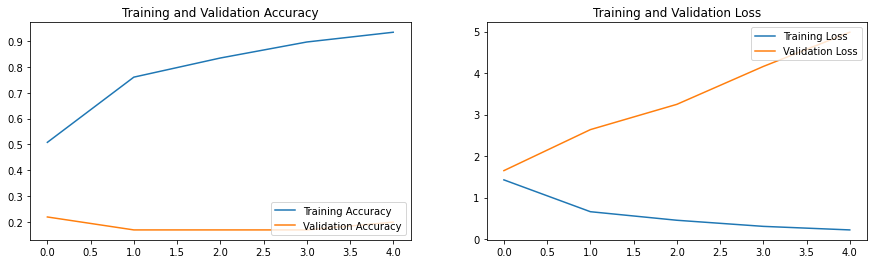

In [17]:
conv_3D7_1=modelbuild3D7()
conv_3D7_1.imageparam(image_height=120,image_width=120)
conv_3D7_1.othergenparam(num_epoches=5,batch_size=40,num_images=20)
conv_3D7_1_model=conv_3D7_1.model_definition()
conv_3D7_1_model.summary()
print("Total Params:", conv_3D7_1_model.count_params())
model7_1 = conv_3D7_1.train_model(conv_3D7_1_model)
plot(model7_1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_13 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 10, 60, 60, 32)   

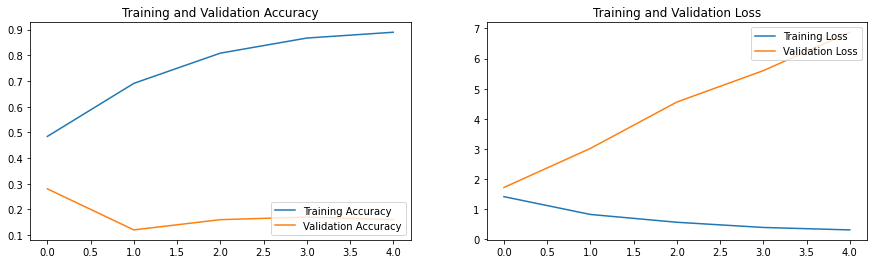

In [18]:
conv_3D7_2=modelbuild3D7()
conv_3D7_2.imageparam(image_height=120,image_width=120)
conv_3D7_2.othergenparam(num_epoches=5,batch_size=50,num_images=20)
conv_3D7_2_model=conv_3D7_2.model_definition()
conv_3D7_2_model.summary()
print("Total Params:", conv_3D7_2_model.count_params())
model7_2 = conv_3D7_2.train_model(conv_3D7_2_model)
plot(model7_2)

In [19]:
#Changing filters to 2,2,2
#Changing number of neurons
class modelbuild3D8(VideoGenerator):
    def model_definition(self,filter=(2,2,2),dense_neurons=64,dropout=0.2):
        input_shape_model = (self.num_images,self.image_width,self.image_height,3)
        model = Sequential()
        model.add(Conv3D(16, filter, padding='same',input_shape=input_shape_model))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(128, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model
        

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 20, 120, 120, 16)  400       
_________________________________________________________________
activation_16 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
activation_17 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 10, 60, 60, 32)   

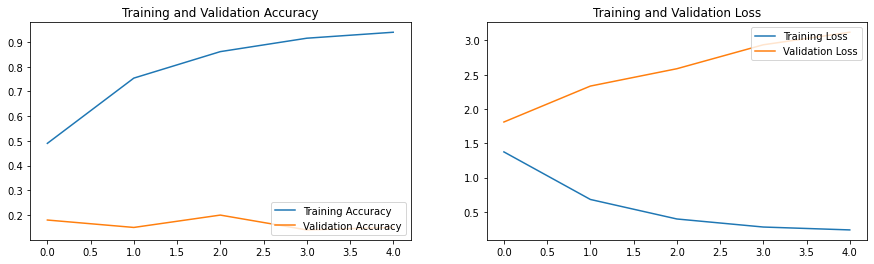

In [20]:
conv_3D8_1=modelbuild3D8()
conv_3D8_1.imageparam(image_height=120,image_width=120)
conv_3D8_1.othergenparam(num_epoches=5,batch_size=40,num_images=20)
conv_3D8_1_model=conv_3D8_1.model_definition()
conv_3D8_1_model.summary()
print("Total Params:", conv_3D8_1_model.count_params())
model8_1 = conv_3D8_1.train_model(conv_3D8_1_model)
plot(model8_1)

In [21]:
# Changing Optimiser to sgd
class modelbuild3D9(VideoGenerator):
    def model_definition(self,filter=(2,2,2),dense_neurons=64,dropout=0.2):
        input_shape_model = (self.num_images,self.image_width,self.image_height,3)
        model = Sequential()
        model.add(Conv3D(16, filter, padding='same',input_shape=input_shape_model))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(128, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model
        

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 20, 120, 120, 16)  400       
_________________________________________________________________
activation_20 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
activation_21 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 10, 60, 60, 32)   

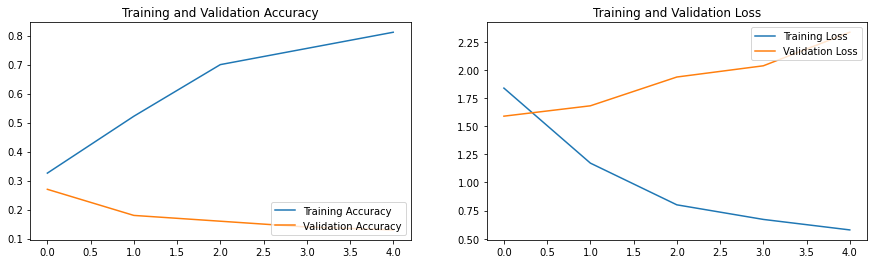

In [22]:
conv_3D9_1=modelbuild3D9()
conv_3D9_1.imageparam(image_height=120,image_width=120)
conv_3D9_1.othergenparam(num_epoches=5,batch_size=40,num_images=20)
conv_3D9_1_model=conv_3D9_1.model_definition()
conv_3D9_1_model.summary()
print("Total Params:", conv_3D9_1_model.count_params())
model9_1 = conv_3D9_1.train_model(conv_3D9_1_model)
plot(model9_1)

In [23]:
# Changing to 256 neurons 
class modelbuild3D10(VideoGenerator):
    def model_definition(self,filter=(2,2,2),dense_neurons=256,dropout=0.2):
        input_shape_model = (self.num_images,self.image_width,self.image_height,3)
        model = Sequential()
        model.add(Conv3D(16, filter, padding='same',input_shape=input_shape_model))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(128, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model
        

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 20, 120, 120, 16)  400       
_________________________________________________________________
activation_24 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
activation_25 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 10, 60, 60, 32)   

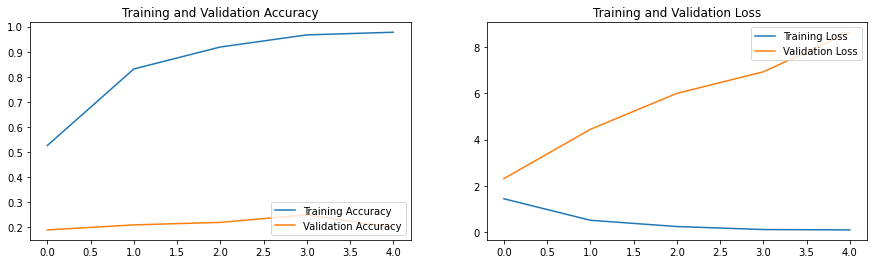

In [24]:
conv_3D10_1=modelbuild3D10()
conv_3D10_1.imageparam(image_height=120,image_width=120)
conv_3D10_1.othergenparam(num_epoches=5,batch_size=40,num_images=20)
conv_3D10_1_model=conv_3D10_1.model_definition()
conv_3D10_1_model.summary()
print("Total Params:", conv_3D10_1_model.count_params())
model10_1 = conv_3D10_1.train_model(conv_3D10_1_model)
plot(model10_1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_28 (Conv3D)           (None, 25, 120, 120, 16)  400       
_________________________________________________________________
activation_28 (Activation)   (None, 25, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 25, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 12, 60, 60, 16)    0         
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 12, 60, 60, 32)    4128      
_________________________________________________________________
activation_29 (Activation)   (None, 12, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 12, 60, 60, 32)   

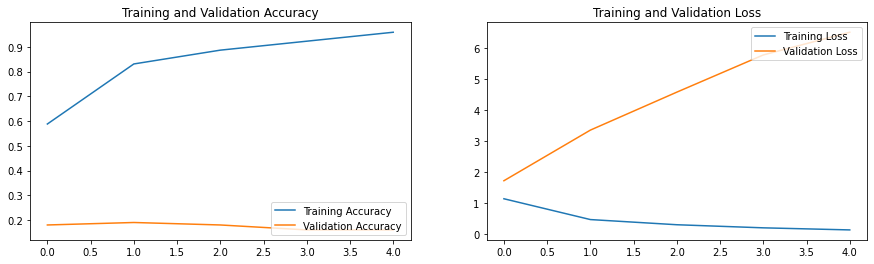

In [25]:
conv_3D10_2=modelbuild3D10()
conv_3D10_2.imageparam(image_height=120,image_width=120)
conv_3D10_2.othergenparam(num_epoches=5,batch_size=40,num_images=25)
conv_3D10_2_model=conv_3D10_2.model_definition()
conv_3D10_2_model.summary()
print("Total Params:", conv_3D10_2_model.count_params())
model10_2 = conv_3D10_2.train_model(conv_3D10_2_model)
plot(model10_2)

In [11]:
# Further Analysing Using a model having 128 neurons by decreasing the batch size further
class modelbuild3D11(VideoGenerator):
    def model_definition(self,filter=(3,3,3),dense_neurons=128,dropout=0.25):
        input_shape_model = (self.num_images,self.image_width,self.image_height,3)
        model = Sequential()
        model.add(Conv3D(16, filter, padding='same',input_shape=input_shape_model))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filter, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model
        

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_36 (Conv3D)           (None, 25, 120, 120, 16)  1312      
_________________________________________________________________
activation_36 (Activation)   (None, 25, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 25, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_36 (MaxPooling (None, 12, 60, 60, 16)    0         
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 12, 60, 60, 32)    13856     
_________________________________________________________________
activation_37 (Activation)   (None, 12, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 12, 60, 60, 32)   

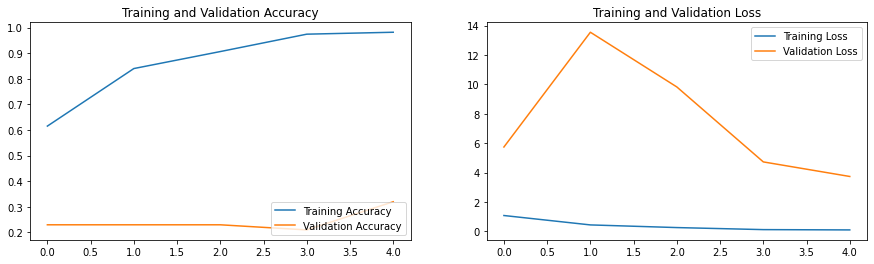

In [28]:
conv_3D11_1=modelbuild3D11()
conv_3D11_1.imageparam(image_height=120,image_width=120)
conv_3D11_1.othergenparam(num_epoches=5,batch_size=20,num_images=25)
conv_3D11_1_model=conv_3D11_1.model_definition()
conv_3D11_1_model.summary()
print("Total Params:", conv_3D11_1_model.count_params())
model11_1 = conv_3D11_1.train_model(conv_3D11_1_model)
plot(model11_1)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_39 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_39 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_58 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_39 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_40 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_40 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_59 (Batc (None, 10, 60, 60, 32)  

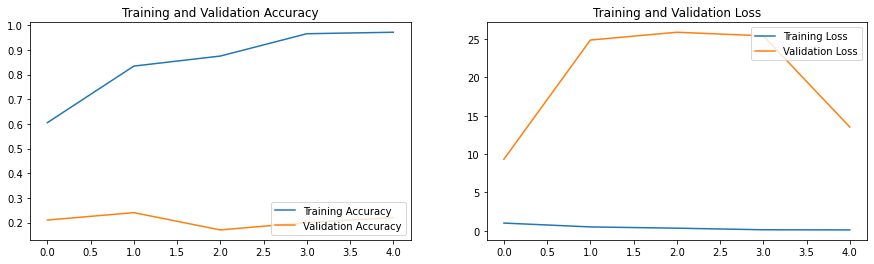

In [29]:
conv_3D11_2=modelbuild3D11()
conv_3D11_2.imageparam(image_height=120,image_width=120)
conv_3D11_2.othergenparam(num_epoches=5,batch_size=20,num_images=20)
conv_3D11_2_model=conv_3D11_2.model_definition()
conv_3D11_2_model.summary()
print("Total Params:", conv_3D11_2_model.count_params())
model11_2 = conv_3D11_2.train_model(conv_3D11_2_model)
plot(model11_2)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_42 (Conv3D)           (None, 25, 140, 140, 16)  1312      
_________________________________________________________________
activation_42 (Activation)   (None, 25, 140, 140, 16)  0         
_________________________________________________________________
batch_normalization_62 (Batc (None, 25, 140, 140, 16)  64        
_________________________________________________________________
max_pooling3d_42 (MaxPooling (None, 12, 70, 70, 16)    0         
_________________________________________________________________
conv3d_43 (Conv3D)           (None, 12, 70, 70, 32)    13856     
_________________________________________________________________
activation_43 (Activation)   (None, 12, 70, 70, 32)    0         
_________________________________________________________________
batch_normalization_63 (Batc (None, 12, 70, 70, 32)  

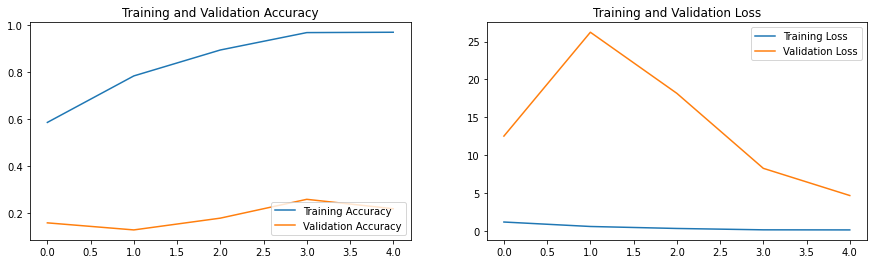

In [30]:
conv_3D11_3=modelbuild3D11()
conv_3D11_3.imageparam(image_height=140,image_width=140)
conv_3D11_3.othergenparam(num_epoches=5,batch_size=20,num_images=25)
conv_3D11_3_model=conv_3D11_3.model_definition()
conv_3D11_3_model.summary()
print("Total Params:", conv_3D11_3_model.count_params())
model11_3 = conv_3D11_3.train_model(conv_3D11_3_model)
plot(model11_3)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_45 (Conv3D)           (None, 28, 120, 120, 16)  1312      
_________________________________________________________________
activation_45 (Activation)   (None, 28, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 28, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_45 (MaxPooling (None, 14, 60, 60, 16)    0         
_________________________________________________________________
conv3d_46 (Conv3D)           (None, 14, 60, 60, 32)    13856     
_________________________________________________________________
activation_46 (Activation)   (None, 14, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_67 (Batc (None, 14, 60, 60, 32)  

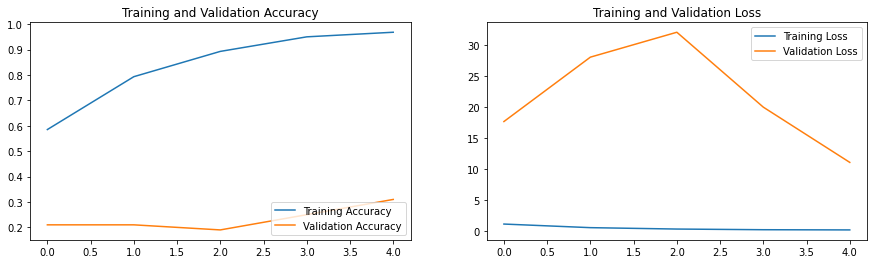

In [31]:
conv_3D11_4=modelbuild3D11()
conv_3D11_4.imageparam(image_height=120,image_width=120)
conv_3D11_4.othergenparam(num_epoches=5,batch_size=20,num_images=28)
conv_3D11_4_model=conv_3D11_4.model_definition()
conv_3D11_4_model.summary()
print("Total Params:", conv_3D11_4_model.count_params())
model11_4 = conv_3D11_4.train_model(conv_3D11_4_model)
plot(model11_4)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_48 (Conv3D)           (None, 25, 120, 120, 16)  1312      
_________________________________________________________________
activation_48 (Activation)   (None, 25, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_70 (Batc (None, 25, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_48 (MaxPooling (None, 12, 60, 60, 16)    0         
_________________________________________________________________
conv3d_49 (Conv3D)           (None, 12, 60, 60, 32)    13856     
_________________________________________________________________
activation_49 (Activation)   (None, 12, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_71 (Batc (None, 12, 60, 60, 32)  

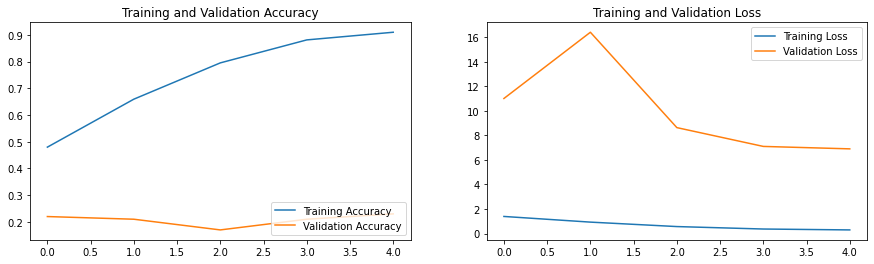

In [32]:
conv_3D11_5=modelbuild3D11()
conv_3D11_5.imageparam(image_height=120,image_width=120)
conv_3D11_5.othergenparam(num_epoches=5,batch_size=20,num_images=25)
conv_3D11_5_model=conv_3D11_5.model_definition(dense_neurons=128,dropout=0.5)
conv_3D11_5_model.summary()
print("Total Params:", conv_3D11_5_model.count_params())
model11_5 = conv_3D11_5.train_model(conv_3D11_5_model)
plot(model11_5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 150, 150, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 150, 150, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 150, 150, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 75, 75, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 75, 75, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 15, 75, 75, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 75, 75, 32)    1

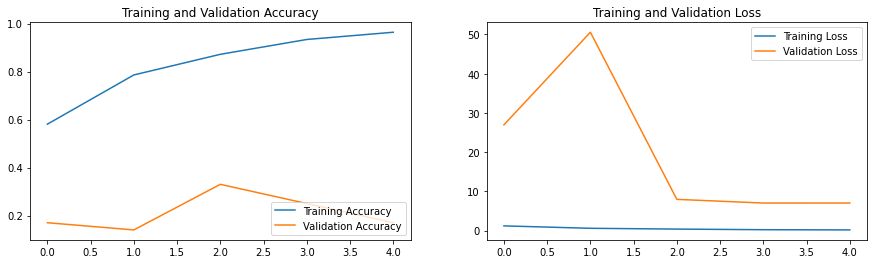

In [12]:
conv_3D11_6=modelbuild3D11()
conv_3D11_6.imageparam(image_height=150,image_width=150)
conv_3D11_6.othergenparam(num_epoches=5,batch_size=16,num_images=30)
conv_3D11_6_model=conv_3D11_6.model_definition(dense_neurons=128,dropout=0.2)
conv_3D11_6_model.summary()
print("Total Params:", conv_3D11_6_model.count_params())
model11_6 = conv_3D11_6.train_model(conv_3D11_6_model)
plot(model11_6)

In [10]:
class modelbuild3D12(VideoGenerator):
    def model_definition(self,filter=(3,3,3),dense_neurons=64,dropout=0.25):
        input_shape_model = (self.num_images,self.image_width,self.image_height,3)
        model = Sequential()
        model.add(Conv3D(16, filter, padding='same',input_shape=input_shape_model))
        model.add(Activation('relu'))
        #model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filter, padding='same'))
        model.add(Activation('relu'))
        #model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filter, padding='same'))
        model.add(Activation('relu'))
        #model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        #model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 20, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_10 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 5, 30, 30, 32)     0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 5, 30, 30, 64)    

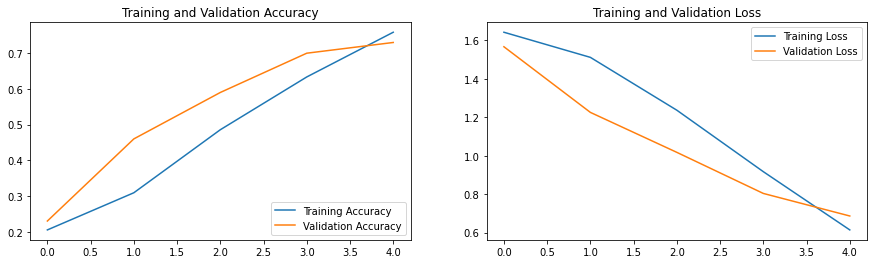

In [17]:
conv_3D12_1=modelbuild3D12()
conv_3D12_1.imageparam(image_height=120,image_width=120)
conv_3D12_1.othergenparam(num_epoches=5,batch_size=20,num_images=20)
conv_3D12_1_model=conv_3D12_1.model_definition(dense_neurons=128,dropout=0.2)
conv_3D12_1_model.summary()
print("Total Params:", conv_3D12_1_model.count_params())
model12_1 = conv_3D12_1.train_model(conv_3D12_1_model)
plot(model12_1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 20, 140, 140, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 20, 140, 140, 16)  0         
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 10, 70, 70, 16)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 10, 70, 70, 32)    13856     
_________________________________________________________________
activation_13 (Activation)   (None, 10, 70, 70, 32)    0         
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 5, 35, 35, 32)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 5, 35, 35, 64)    

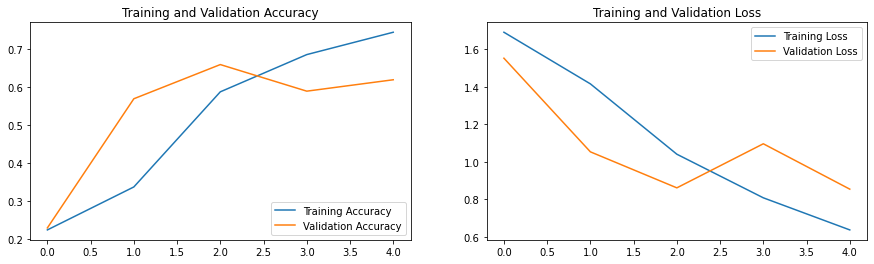

In [18]:
conv_3D12_2=modelbuild3D12()
conv_3D12_2.imageparam(image_height=140,image_width=140)
conv_3D12_2.othergenparam(num_epoches=5,batch_size=20,num_images=20)
conv_3D12_2_model=conv_3D12_2.model_definition(dense_neurons=128,dropout=0.2)
conv_3D12_2_model.summary()
print("Total Params:", conv_3D12_2_model.count_params())
model12_2 = conv_3D12_2.train_model(conv_3D12_2_model)
plot(model12_2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 25, 140, 140, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 25, 140, 140, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 12, 70, 70, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 12, 70, 70, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 12, 70, 70, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 35, 35, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 6, 35, 35, 64)     5

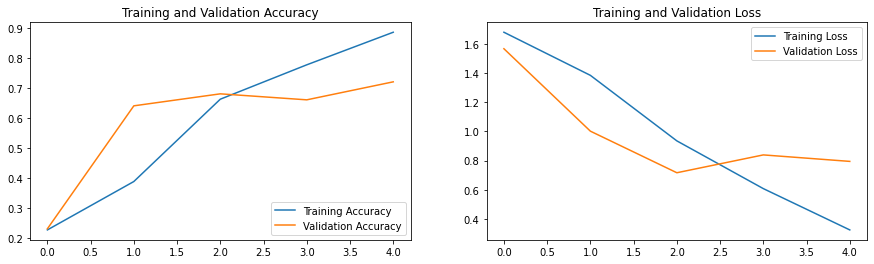

In [11]:
conv_3D12_3=modelbuild3D12()
conv_3D12_3.imageparam(image_height=140,image_width=140)
conv_3D12_3.othergenparam(num_epoches=5,batch_size=20,num_images=25)
conv_3D12_3_model=conv_3D12_3.model_definition(dense_neurons=128,dropout=0.2)
conv_3D12_3_model.summary()
print("Total Params:", conv_3D12_3_model.count_params())
model12_3 = conv_3D12_3.train_model(conv_3D12_3_model)
plot(model12_3)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 25, 120, 120, 16)  1312      
_________________________________________________________________
activation_3 (Activation)    (None, 25, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 12, 60, 60, 16)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 12, 60, 60, 32)    13856     
_________________________________________________________________
activation_4 (Activation)    (None, 12, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 6, 30, 30, 32)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 6, 30, 30, 64)    

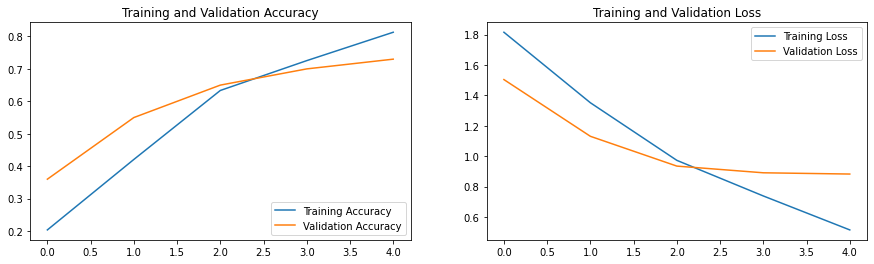

In [12]:
conv_3D12_4=modelbuild3D12()
conv_3D12_4.imageparam(image_height=120,image_width=120)
conv_3D12_4.othergenparam(num_epoches=5,batch_size=20,num_images=25)
conv_3D12_4_model=conv_3D12_4.model_definition(dense_neurons=128,dropout=0.2)
conv_3D12_4_model.summary()
print("Total Params:", conv_3D12_4_model.count_params())
model12_4 = conv_3D12_4.train_model(conv_3D12_4_model)
plot(model12_4)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 25, 120, 120, 16)  1312      
_________________________________________________________________
activation_6 (Activation)    (None, 25, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 12, 60, 60, 16)    0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 12, 60, 60, 32)    13856     
_________________________________________________________________
activation_7 (Activation)    (None, 12, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 6, 30, 30, 32)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 6, 30, 30, 64)    

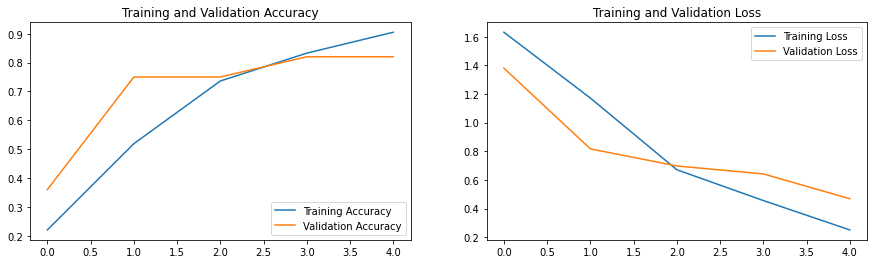

In [13]:
conv_3D12_5=modelbuild3D12()
conv_3D12_5.imageparam(image_height=120,image_width=120)
conv_3D12_5.othergenparam(num_epoches=5,batch_size=15,num_images=25)
conv_3D12_5_model=conv_3D12_5.model_definition(dense_neurons=128,dropout=0.2)
conv_3D12_5_model.summary()
print("Total Params:", conv_3D12_5_model.count_params())
model12_5 = conv_3D12_5.train_model(conv_3D12_5_model)
plot(model12_5)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 25, 120, 120, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 25, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 12, 60, 60, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 12, 60, 60, 32)    13856     
_________________________________________________________________
activation_10 (Activation)   (None, 12, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 6, 30, 30, 32)     0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 6, 30, 30, 64)    

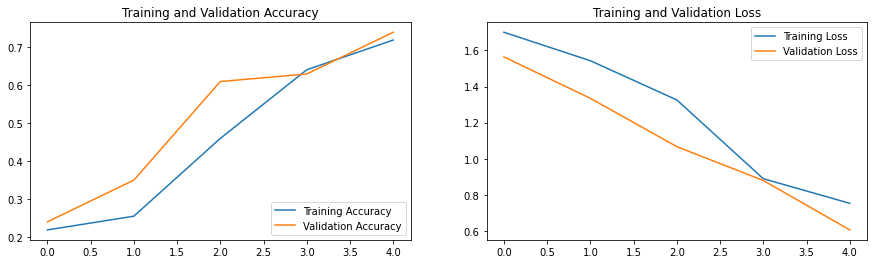

In [14]:
conv_3D12_6=modelbuild3D12()
conv_3D12_6.imageparam(image_height=120,image_width=120)
conv_3D12_6.othergenparam(num_epoches=5,batch_size=15,num_images=25)
conv_3D12_6_model=conv_3D12_6.model_definition(dense_neurons=128,dropout=0.5)
conv_3D12_6_model.summary()
print("Total Params:", conv_3D12_6_model.count_params())
model12_6 = conv_3D12_6.train_model(conv_3D12_6_model)
plot(model12_6)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 25, 120, 120, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 25, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 12, 60, 60, 16)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 12, 60, 60, 32)    13856     
_________________________________________________________________
activation_13 (Activation)   (None, 12, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 6, 30, 30, 32)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 6, 30, 30, 64)    

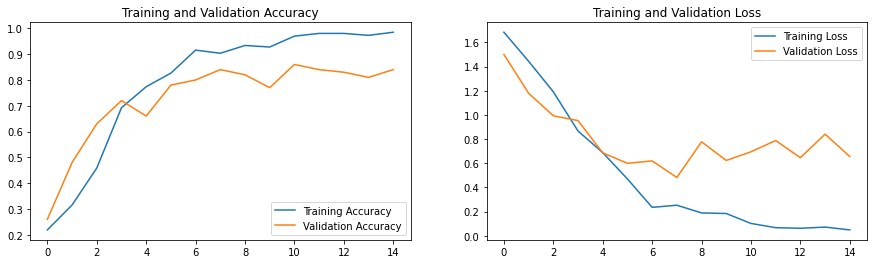

In [15]:
conv_3D12_7=modelbuild3D12()
conv_3D12_7.imageparam(image_height=120,image_width=120)
conv_3D12_7.othergenparam(num_epoches=15,batch_size=15,num_images=25)
conv_3D12_7_model=conv_3D12_7.model_definition(dense_neurons=128,dropout=0.5)
conv_3D12_7_model.summary()
print("Total Params:", conv_3D12_7_model.count_params())
model12_7 = conv_3D12_7.train_model(conv_3D12_7_model)
plot(model12_7)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 22, 120, 120, 16)  1312      
_________________________________________________________________
activation_15 (Activation)   (None, 22, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 11, 60, 60, 16)    0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 11, 60, 60, 32)    13856     
_________________________________________________________________
activation_16 (Activation)   (None, 11, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 5, 30, 30, 32)     0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 5, 30, 30, 64)    

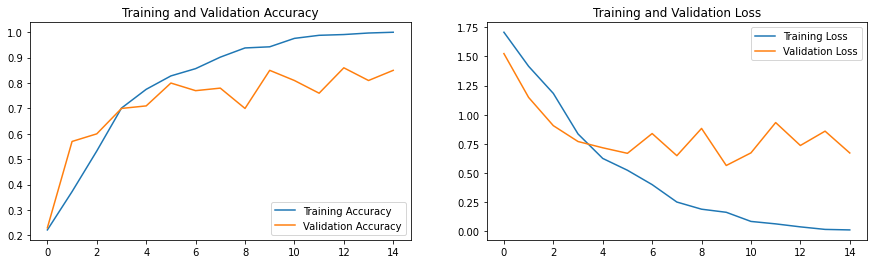

In [16]:
conv_3D12_8=modelbuild3D12()
conv_3D12_8.imageparam(image_height=120,image_width=120)
conv_3D12_8.othergenparam(num_epoches=15,batch_size=20,num_images=22)
conv_3D12_8_model=conv_3D12_8.model_definition(dense_neurons=128,dropout=0.2)
conv_3D12_8_model.summary()
print("Total Params:", conv_3D12_8_model.count_params())
model12_8 = conv_3D12_8.train_model(conv_3D12_8_model)
plot(model12_8)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_18 (Conv3D)           (None, 22, 120, 120, 16)  1312      
_________________________________________________________________
activation_18 (Activation)   (None, 22, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 11, 60, 60, 16)    0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 11, 60, 60, 32)    13856     
_________________________________________________________________
activation_19 (Activation)   (None, 11, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 5, 30, 30, 32)     0         
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 5, 30, 30, 64)    

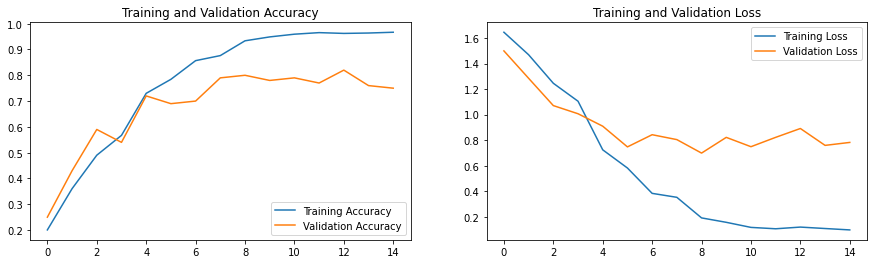

In [17]:
conv_3D12_9=modelbuild3D12()
conv_3D12_9.imageparam(image_height=120,image_width=120)
conv_3D12_9.othergenparam(num_epoches=15,batch_size=20,num_images=22)
conv_3D12_9_model=conv_3D12_9.model_definition(dense_neurons=128,dropout=0.5)
conv_3D12_9_model.summary()
print("Total Params:", conv_3D12_9_model.count_params())
model12_9 = conv_3D12_9.train_model(conv_3D12_9_model)
plot(model12_9)

In [11]:
# Removing Padding
class modelbuild3D13(VideoGenerator):
    def model_definition(self,filter=(3,3,3),dense_neurons=128,dropout=0.5):
        input_shape_model = (self.num_images,self.image_width,self.image_height,3)
        model = Sequential()
        
        model.add(Conv3D(16, filter,input_shape=input_shape_model))
        model.add(Activation('relu'))
        #model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filter))
        model.add(Activation('relu'))
        #model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filter))
        model.add(Activation('relu'))
        #model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        #model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_36 (Conv3D)           (None, 21, 118, 118, 16)  1312      
_________________________________________________________________
activation_36 (Activation)   (None, 21, 118, 118, 16)  0         
_________________________________________________________________
max_pooling3d_36 (MaxPooling (None, 10, 59, 59, 16)    0         
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 8, 57, 57, 32)     13856     
_________________________________________________________________
activation_37 (Activation)   (None, 8, 57, 57, 32)     0         
_________________________________________________________________
max_pooling3d_37 (MaxPooling (None, 4, 28, 28, 32)     0         
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 2, 26, 26, 64)   

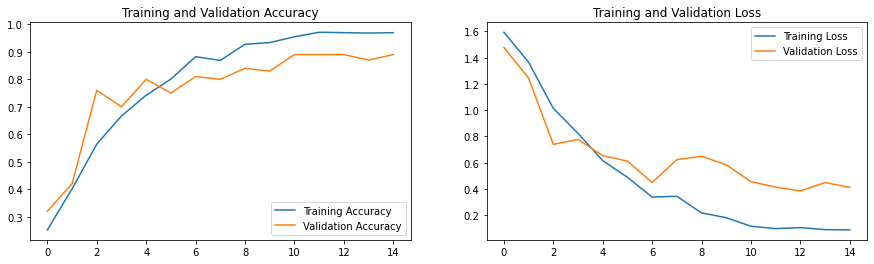

In [26]:
conv_3D13_1=modelbuild3D13()
conv_3D13_1.imageparam(image_height=120,image_width=120)
conv_3D13_1.othergenparam(num_epoches=15,batch_size=20,num_images=23)
conv_3D13_1_model=conv_3D13_1.model_definition()
conv_3D13_1_model.summary()
print("Total Params:", conv_3D13_1_model.count_params())
model13_1 = conv_3D13_1.train_model(conv_3D13_1_model)
plot(model13_1)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_39 (Conv3D)           (None, 21, 118, 118, 16)  1312      
_________________________________________________________________
activation_39 (Activation)   (None, 21, 118, 118, 16)  0         
_________________________________________________________________
max_pooling3d_39 (MaxPooling (None, 10, 59, 59, 16)    0         
_________________________________________________________________
conv3d_40 (Conv3D)           (None, 8, 57, 57, 32)     13856     
_________________________________________________________________
activation_40 (Activation)   (None, 8, 57, 57, 32)     0         
_________________________________________________________________
max_pooling3d_40 (MaxPooling (None, 4, 28, 28, 32)     0         
_________________________________________________________________
conv3d_41 (Conv3D)           (None, 2, 26, 26, 64)   

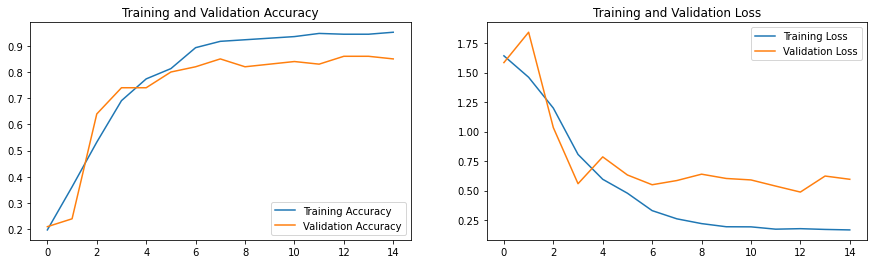

In [27]:
conv_3D13_2=modelbuild3D13()
conv_3D13_2.imageparam(image_height=120,image_width=120)
conv_3D13_2.othergenparam(num_epoches=15,batch_size=20,num_images=23)
conv_3D13_2_model=conv_3D13_2.model_definition(dropout=0.2)
conv_3D13_2_model.summary()
print("Total Params:", conv_3D13_2_model.count_params())
model13_2 = conv_3D13_2.train_model(conv_3D13_2_model)
plot(model13_2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 21, 118, 118, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 21, 118, 118, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 59, 59, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 57, 57, 32)     13856     
_________________________________________________________________
activation_1 (Activation)    (None, 8, 57, 57, 32)     0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 4, 28, 28, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 26, 26, 64)     5

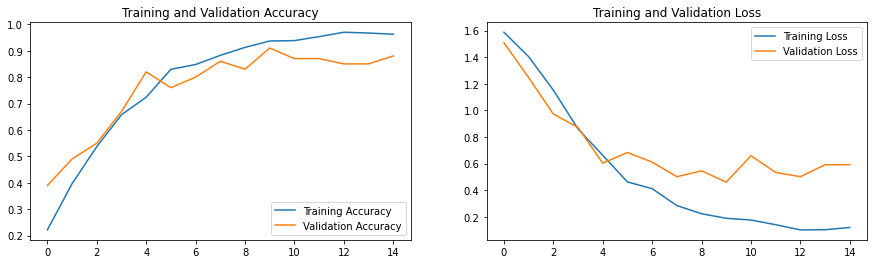

In [12]:
conv_3D13_3=modelbuild3D13()
conv_3D13_3.imageparam(image_height=120,image_width=120)
conv_3D13_3.othergenparam(num_epoches=15,batch_size=18,num_images=23)
conv_3D13_3_model=conv_3D13_3.model_definition()
conv_3D13_3_model.summary()
print("Total Params:", conv_3D13_3_model.count_params())
model13_3 = conv_3D13_3.train_model(conv_3D13_3_model)
plot(model13_3)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 20, 118, 118, 16)  1312      
_________________________________________________________________
activation_3 (Activation)    (None, 20, 118, 118, 16)  0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 10, 59, 59, 16)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 8, 57, 57, 32)     13856     
_________________________________________________________________
activation_4 (Activation)    (None, 8, 57, 57, 32)     0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 4, 28, 28, 32)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 2, 26, 26, 64)    

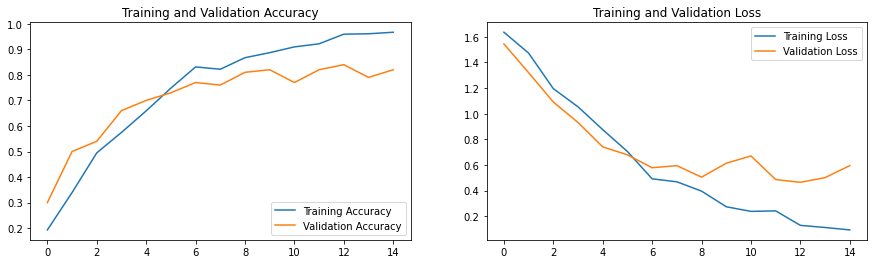

In [13]:
conv_3D13_4=modelbuild3D13()
conv_3D13_4.imageparam(image_height=120,image_width=120)
conv_3D13_4.othergenparam(num_epoches=15,batch_size=20,num_images=22)
conv_3D13_4_model=conv_3D13_4.model_definition()
conv_3D13_4_model.summary()
print("Total Params:", conv_3D13_4_model.count_params())
model13_4 = conv_3D13_4.train_model(conv_3D13_4_model)
plot(model13_4)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 22, 118, 118, 16)  1312      
_________________________________________________________________
activation_6 (Activation)    (None, 22, 118, 118, 16)  0         
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 11, 59, 59, 16)    0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 9, 57, 57, 32)     13856     
_________________________________________________________________
activation_7 (Activation)    (None, 9, 57, 57, 32)     0         
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 4, 28, 28, 32)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 2, 26, 26, 64)    

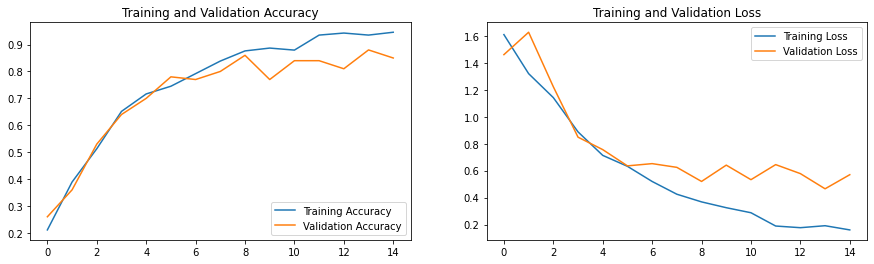

In [14]:
conv_3D13_5=modelbuild3D13()
conv_3D13_5.imageparam(image_height=120,image_width=120)
conv_3D13_5.othergenparam(num_epoches=15,batch_size=20,num_images=24)
conv_3D13_5_model=conv_3D13_5.model_definition()
conv_3D13_5_model.summary()
print("Total Params:", conv_3D13_5_model.count_params())
model13_5 = conv_3D13_5.train_model(conv_3D13_5_model)
plot(model13_5)

#### Building 2D RNN network

In [10]:
class Model2DRNN_1(VideoGenerator):

    def model_definition(self,filter=(3,3),dense_neurons=64,dropout=0.25):

        input_shape_model = (self.num_images,self.image_width,self.image_height,3)
        
        model = Sequential()
        model.add(TimeDistributed(Conv2D(16, filter , padding='same', activation='relu'),input_shape=input_shape_model))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
                
        model.add(TimeDistributed(Conv2D(32, filter , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
                
        model.add(TimeDistributed(Conv2D(64, filter , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
                
        model.add(TimeDistributed(Conv2D(128, filter , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
                
        model.add(TimeDistributed(Conv2D(256, filter , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(dense_neurons))
        model.add(Dropout(dropout))
                
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
                
        model.add(Dense(5, activation='softmax'))

        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        #K.set_value(model.optimizer.learning_rate,0.0002)
        #print("The learning rate is: {}".format(K.eval(model.optimizer.lr)))
        return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 30, 30, 64)    1

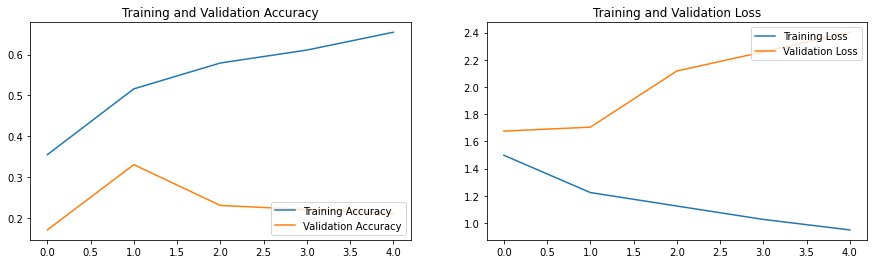

In [11]:
conv_2drnn_1=Model2DRNN_1()
conv_2drnn_1.imageparam(image_height=120,image_width=120)
conv_2drnn_1.othergenparam(num_epoches=5,batch_size=50,num_images=15)
conv_2drnn_1_model=conv_2drnn_1.model_definition()
conv_2drnn_1_model.summary()
print("Total Params:", conv_2drnn_1_model.count_params())
model2d1_1 = conv_2drnn_1.train_model(conv_2drnn_1_model)
plot(model2d1_1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 15, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 15, 30, 30, 64)   

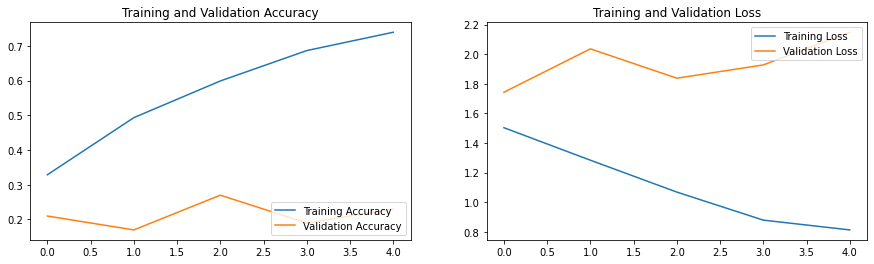

In [12]:
conv_2drnn_2=Model2DRNN_1()
conv_2drnn_2.imageparam(image_height=120,image_width=120)
conv_2drnn_2.othergenparam(num_epoches=5,batch_size=20,num_images=15)
conv_2drnn_2_model=conv_2drnn_2.model_definition()
conv_2drnn_2_model.summary()
print("Total Params:", conv_2drnn_2_model.count_params())
model2d1_2 = conv_2drnn_2.train_model(conv_2drnn_2_model)
plot(model2d1_2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_32 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_33 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_34 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_36 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_37 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_38 (TimeDis (None, 20, 30, 30, 64)   

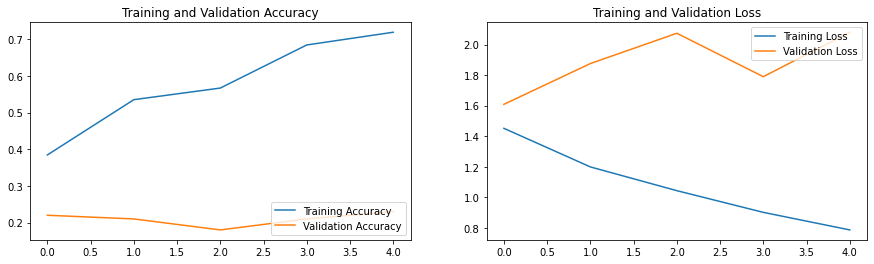

In [13]:
conv_2drnn_3=Model2DRNN_1()
conv_2drnn_3.imageparam(image_height=120,image_width=120)
conv_2drnn_3.othergenparam(num_epoches=5,batch_size=20,num_images=20)
conv_2drnn_3_model=conv_2drnn_3.model_definition()
conv_2drnn_3_model.summary()
print("Total Params:", conv_2drnn_3_model.count_params())
model2d1_3 = conv_2drnn_3.train_model(conv_2drnn_3_model)
plot(model2d1_3)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_48 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_49 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_50 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_51 (TimeDis (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_52 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_53 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_54 (TimeDis (None, 20, 30, 30, 64)   

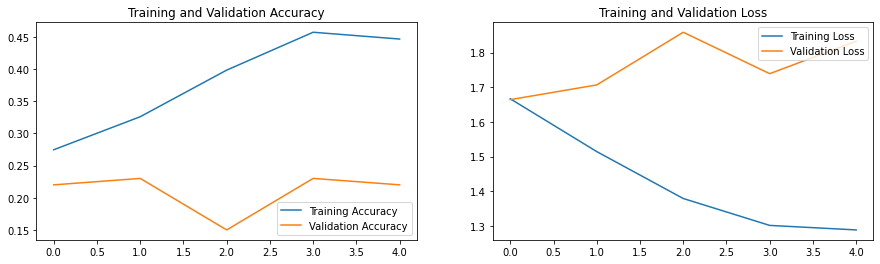

In [14]:
conv_2drnn_4=Model2DRNN_1()
conv_2drnn_4.imageparam(image_height=120,image_width=120)
conv_2drnn_4.othergenparam(num_epoches=5,batch_size=20,num_images=20)
conv_2drnn_4_model=conv_2drnn_4.model_definition(dropout=0.5)
conv_2drnn_4_model.summary()
print("Total Params:", conv_2drnn_4_model.count_params())
model2d1_4 = conv_2drnn_4.train_model(conv_2drnn_4_model)
plot(model2d1_4)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_64 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_65 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_66 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_67 (TimeDis (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_68 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_69 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_70 (TimeDis (None, 20, 30, 30, 64)   

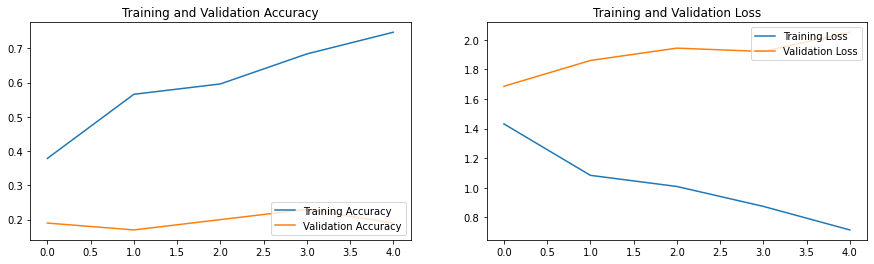

In [15]:
conv_2drnn_5=Model2DRNN_1()
conv_2drnn_5.imageparam(image_height=120,image_width=120)
conv_2drnn_5.othergenparam(num_epoches=5,batch_size=20,num_images=20)
conv_2drnn_5_model=conv_2drnn_5.model_definition(dense_neurons=128)
conv_2drnn_5_model.summary()
print("Total Params:", conv_2drnn_5_model.count_params())
model2d1_5 = conv_2drnn_5.train_model(conv_2drnn_5_model)
plot(model2d1_5)

In [16]:
#GRU
class Model2DRNN_2(VideoGenerator):

    def model_definition(self,filter=(3,3),dense_neurons=64,dropout=0.25):

        input_shape_model = (self.num_images,self.image_width,self.image_height,3)
        
        model = Sequential()
        model.add(TimeDistributed(Conv2D(16, filter , padding='same', activation='relu'),input_shape=input_shape_model))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
                
        model.add(TimeDistributed(Conv2D(32, filter , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
                
        model.add(TimeDistributed(Conv2D(64, filter , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
                
        model.add(TimeDistributed(Conv2D(128, filter , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
                
        model.add(TimeDistributed(Conv2D(256, filter , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(GRU(dense_neurons))
        model.add(Dropout(dropout))
                
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
                
        model.add(Dense(5, activation='softmax'))

        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_80 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_81 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_82 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_83 (TimeDis (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_84 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_85 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_86 (TimeDis (None, 20, 30, 30, 64)   

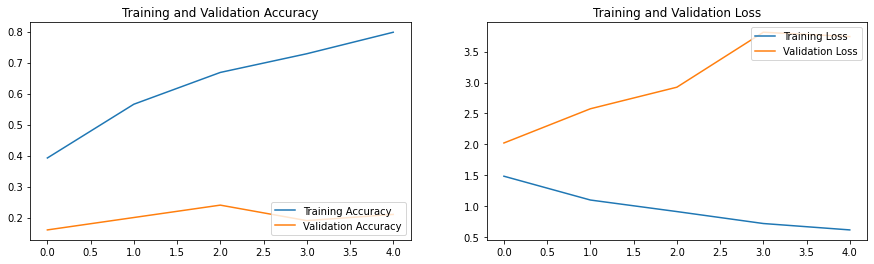

In [17]:
conv_2drnn_2_1=Model2DRNN_2()
conv_2drnn_2_1.imageparam(image_height=120,image_width=120)
conv_2drnn_2_1.othergenparam(num_epoches=5,batch_size=20,num_images=20)
conv_2drnn_2_1_model=conv_2drnn_2_1.model_definition()
conv_2drnn_2_1_model.summary()
print("Total Params:", conv_2drnn_2_1_model.count_params())
model2d2_1 = conv_2drnn_2_1.train_model(conv_2drnn_2_1_model)
plot(model2d2_1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_96 (TimeDis (None, 24, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_97 (TimeDis (None, 24, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_98 (TimeDis (None, 24, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_99 (TimeDis (None, 24, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_100 (TimeDi (None, 24, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_101 (TimeDi (None, 24, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_102 (TimeDi (None, 24, 30, 30, 64)   

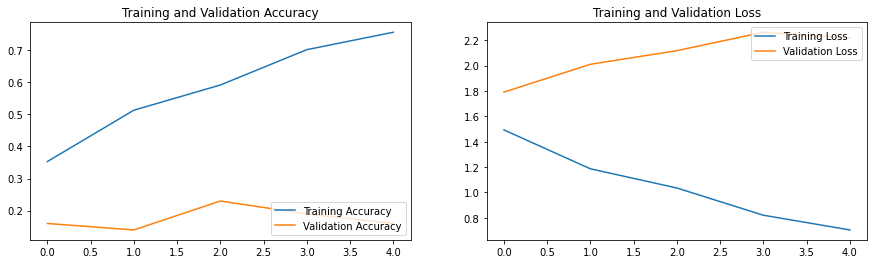

In [18]:
conv_2drnn_2_2=Model2DRNN_2()
conv_2drnn_2_2.imageparam(image_height=120,image_width=120)
conv_2drnn_2_2.othergenparam(num_epoches=5,batch_size=20,num_images=24)
conv_2drnn_2_2_model=conv_2drnn_2_2.model_definition()
conv_2drnn_2_2_model.summary()
print("Total Params:", conv_2drnn_2_2_model.count_params())
model2d2_2 = conv_2drnn_2_2.train_model(conv_2drnn_2_2_model)
plot(model2d2_2)

In [20]:
#Simple RNN
#Trying Simple RNN
class Model2DRNN_3(VideoGenerator):

    def model_definition(self,filter=(3,3),dense_neurons=64,dropout=0.25):

        input_shape_model = (self.num_images,self.image_width,self.image_height,3)
        
        model = Sequential()
        model.add(TimeDistributed(Conv2D(16, filter , padding='same', activation='relu'),input_shape=input_shape_model))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
                
        model.add(TimeDistributed(Conv2D(32, filter , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
                
        model.add(TimeDistributed(Conv2D(64, filter , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
                
        model.add(TimeDistributed(Conv2D(128, filter , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
                
        model.add(TimeDistributed(Conv2D(256, filter , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(SimpleRNN(dense_neurons))
        model.add(Dropout(dropout))
                
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
                
        model.add(Dense(5, activation='softmax'))

        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_112 (TimeDi (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_113 (TimeDi (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_114 (TimeDi (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_115 (TimeDi (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_116 (TimeDi (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_117 (TimeDi (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_118 (TimeDi (None, 20, 30, 30, 64)   

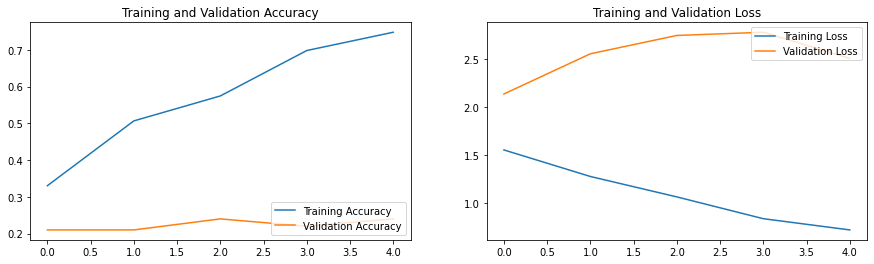

In [21]:
conv_2drnn_3_1=Model2DRNN_3()
conv_2drnn_3_1.imageparam(image_height=120,image_width=120)
conv_2drnn_3_1.othergenparam(num_epoches=5,batch_size=20,num_images=20)
conv_2drnn_3_1_model=conv_2drnn_3_1.model_definition()
conv_2drnn_3_1_model.summary()
print("Total Params:", conv_2drnn_3_1_model.count_params())
model2d3_1 = conv_2drnn_3_1.train_model(conv_2drnn_3_1_model)
plot(model2d3_1)

In [10]:
#GRU and removing BN
class Model2DRNN_4(VideoGenerator):

    def model_definition(self,filter=(3,3),dense_neurons=64,dropout=0.25):

        input_shape_model = (self.num_images,self.image_width,self.image_height,3)
        
        model = Sequential()
        model.add(TimeDistributed(Conv2D(16, filter , padding='same', activation='relu'),input_shape=input_shape_model))
       # model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
                
        model.add(TimeDistributed(Conv2D(32, filter , padding='same', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
                
        model.add(TimeDistributed(Conv2D(64, filter , padding='same', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
                
        model.add(TimeDistributed(Conv2D(128, filter , padding='same', activation='relu')))
        #model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
                
        model.add(TimeDistributed(Conv2D(256, filter , padding='same', activation='relu')))
        #model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(GRU(dense_neurons))
        model.add(Dropout(dropout))
                
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
                
        model.add(Dense(5, activation='softmax'))

        optimiser = 'adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return model

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_128 (TimeDi (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_129 (TimeDi (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_130 (TimeDi (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_131 (TimeDi (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_132 (TimeDi (None, 20, 30, 30, 64)    18496     
_________________________________________________________________
time_distributed_133 (TimeDi (None, 20, 15, 15, 64)    0         
_________________________________________________________________
time_distributed_134 (TimeDi (None, 20, 15, 15, 128)  

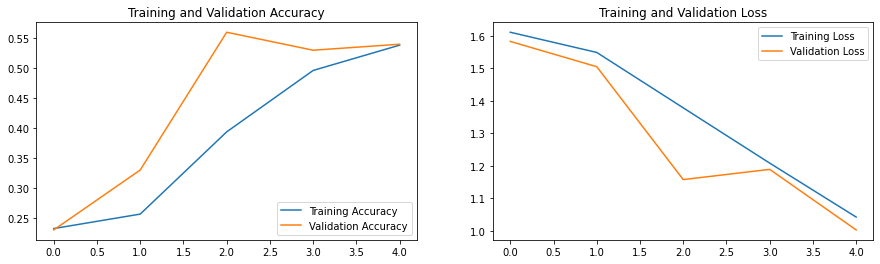

In [23]:
conv_2drnn_4_1=Model2DRNN_4()
conv_2drnn_4_1.imageparam(image_height=120,image_width=120)
conv_2drnn_4_1.othergenparam(num_epoches=5,batch_size=20,num_images=20)
conv_2drnn_4_1_model=conv_2drnn_4_1.model_definition()
conv_2drnn_4_1_model.summary()
print("Total Params:", conv_2drnn_4_1_model.count_params())
model2d4_1 = conv_2drnn_4_1.train_model(conv_2drnn_4_1_model)
plot(model2d4_1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 30, 30, 64)    18496     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 15, 15, 64)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 15, 15, 128)   7

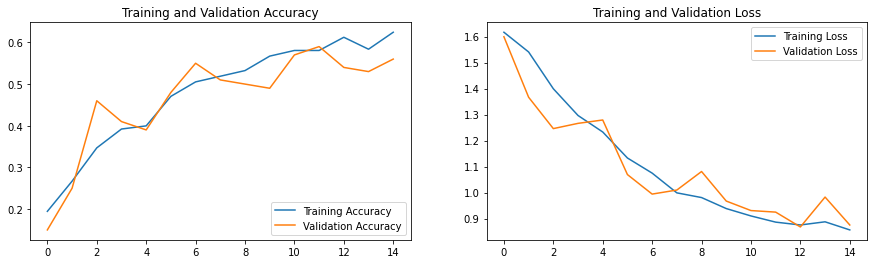

In [11]:
conv_2drnn_4_2=Model2DRNN_4()
conv_2drnn_4_2.imageparam(image_height=120,image_width=120)
conv_2drnn_4_2.othergenparam(num_epoches=15,batch_size=20,num_images=18)
conv_2drnn_4_2_model=conv_2drnn_4_2.model_definition()
conv_2drnn_4_2_model.summary()
print("Total Params:", conv_2drnn_4_2_model.count_params())
model2d4_2 = conv_2drnn_4_2.train_model(conv_2drnn_4_2_model)
plot(model2d4_2)

### Conclusion : Best Model

Model Architecture - conv_3D13_1_model,
Model Name- model13_1,
Total parameters(~1.5M)- 1,455,749  
Epochs- 15, Image size - 120,120, Number of images per video – 23, Batch Size- 20, Filter Size – (3,3,3)
Training accuracy- 96.9% ; Validation-accuracy- 89%